## A linear model with GPy.

**Background**: I'm working on a project aiming to extrapolate dialysis patient results over a 100-hour window (I'll write future blog posts on this!). I'm working with James Fotheringham (Consultant Nephrologist) who brilliantly bridges the gap between clinic and research - allowing ivory-tower researchers (me) to get our expertise applied in the real world to useful applications.

Part of this project is the prediction of the patient's weight. We'll consider a simple model.

When a patient has haemodialysis, they will have fluid removed. If this doesn't happen frequently or successfully enough the patient can experience *fluid overload*. Each dialysis session (in this simplified model) brings the patient's weight back down to their dry-weight. Then this weight will increase (roughly linearly) as time goes by until their next dialysis session. I model their weight $w(t,s)$ with a slow-moving function of time-since-start-of-trial, $f(t)$, added to a linear function of time-since-last-dialysis-session, $g(s)$:
 
 $$w(t,s) = f(t) + g(s)$$
 
For now we'll ignore f, and just consider g. This is a simple linear function $g(s) = s*w$. The gradient $w$ describes how much their weight increases for each day it's been since dialysis.

We could estimate this from previous data from that patient (e.g. by fitting a Gaussian Process model to the data). But if the patient is new, we might want to provide a prior distribution on this parameter. We could get this by considering what gradient other similar patients have (e.g. those with the same age, vintage, gender, weight, comorbidity, etc might have a similar gradient)${}^1$.

So our model is: $g(s) = \phi(s)w$ where we have a prior on $w \sim N(\mu_p, \sigma_p^2)$.

If we find the mean and covariance of $g(s)$:

$$E[g(s)] = \phi(s) E[w] = \phi(s) \mu_p$$

and,

$$cov = E[g(s)g(s')] - E[g(s)]E[g(s')] = \phi(s) E[ww^\top] \phi(s') - \phi(s) \phi(s') E[w] E[w] = \phi(s) \sigma_p^2 \phi(s')$$

We can then use conditional probability to make predictions with this distribution:

mean,
$$\mu = \phi(x_*)\mu_p + k_*^\top K^{-1} (Y-\phi(X)\mu_p)$$

and covariance,

$$\sigma^2 = K_{**} - k_*^\top K^{-1} k_*$$

where $k_*$ and $K$ are as usual the covariance between training and test points, and between training points, respectively. 

2.97547169811 0.085141509434


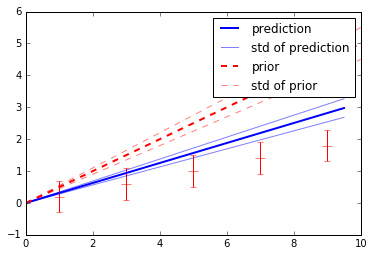

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#X = np.array([7,8])*1.0
#Y = np.array([7,8])*0.2
X = np.arange(1,10,2.0)*1.0
Y = X*0.2
Xstars = np.arange(0,10,0.5)

priormean = 0.5
priorvariance = 0.05**2
noisevar = 0.5**2

def phi(t):
    return t

def kern(s,t):
    return phi(s)*(priorvariance)*phi(t)

K = np.zeros([X.shape[0],X.shape[0]])
for si,s in enumerate(X):
    for ti,t in enumerate(X):
        K[si,ti] = kern(s,t)
K += np.eye(K.shape[0])*noisevar

resmu = []
ressigmasqr = []
for Xstar in Xstars:
    kstar = np.zeros([X.shape[0],1])
    for si,s in enumerate(X):
        kstar[si,0] = kern(s,Xstar)

    
    Mu = phi(X)*priormean
    Mustar = phi(Xstar) * priormean
    mu = Mustar + np.dot(kstar.T, np.dot(np.linalg.inv(K), (Y-Mu)))

    sigmasqr = kern(Xstar,Xstar) - np.dot(kstar.T,np.dot(np.linalg.inv(K),kstar))
    resmu.append(mu[0])
    ressigmasqr.append(sigmasqr[0])
resmu = np.array(resmu)
ressigmasqr = np.array(ressigmasqr)[:,0]


plt.plot(Xstars,resmu,'b-',lw=2,label='prediction');
plt.plot(Xstars,resmu+np.sqrt(ressigmasqr),'b-',alpha=0.5,label='std of prediction');
plt.plot(Xstars,resmu-np.sqrt(ressigmasqr),'b-',alpha=0.5);
plt.errorbar(X,Y,np.sqrt(noisevar),ecolor='r',fmt='r+',markersize=10)
plt.plot([0,10],[0,priormean*10],'r--',lw=2,label='prior');
plt.plot([0,10],[0,priormean*10-np.sqrt(priorvariance)*10],'r--',alpha=0.5,label='std of prior');
plt.plot([0,10],[0,priormean*10+np.sqrt(priorvariance)*10],'r--',alpha=0.5);
plt.legend()
print mu[0],sigmasqr[0,0]

## MCMC to check answer

To test this I can perform numerical approximation with MCMC:

In [13]:
from scipy.stats import norm
gradient = np.random.randn()*np.sqrt(priorvariance)
results = []
oldp = -np.infty
for it in range(10000):
    newgradient = gradient + np.random.randn()
    
    #calc p(gradient):
    #print "newg:    ",newgradient
    pg = np.log(norm(priormean,np.sqrt(priorvariance)).pdf(newgradient))
    #print "pg:      ",pg
    #calc p(data|gradient):
    p = np.sum(np.log(norm(phi(X)*newgradient,np.sqrt(noisevar)).pdf(Y))) + pg
    #print "p:       ",p
    #print "oldp:    ",oldp
    logratio = p-oldp
    #print "logratio:",logratio
    #print "----"
    if logratio>0:
        gradient = newgradient
        results.append(gradient)
        oldp = p
        #print "TAKEN"
    else:
        if np.random.rand()<np.exp(logratio):
            gradient = newgradient
            results.append(gradient)
            oldp = p
            #print "TAKEN"        
results = results[50:]
results = results[0::2]

/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


0.317027608742
0.0387234905112


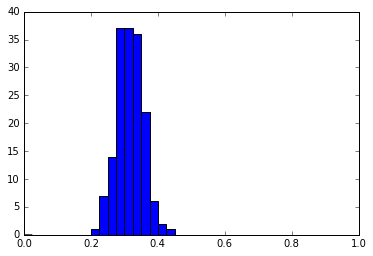

In [14]:
plt.hist(results,40,range=[0,1]);
print np.mean(results)
print np.std(results)

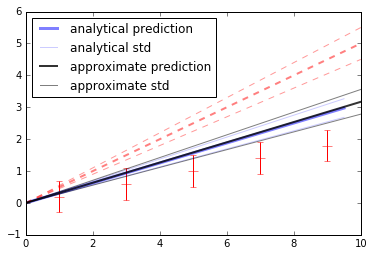

In [16]:
plt.plot(Xstars,resmu,'b-',lw=3,alpha=0.5,label="analytical prediction");
plt.plot(Xstars,resmu+np.sqrt(ressigmasqr),'b-',alpha=0.2,label="analytical std");
plt.plot(Xstars,resmu-np.sqrt(ressigmasqr),'b-',alpha=0.2);
plt.errorbar(X,Y,np.sqrt(noisevar),ecolor='r',fmt='r+',markersize=10)
plt.plot([0,10],[0,priormean*10],'r--',lw=2,alpha=0.5);
plt.plot([0,10],[0,priormean*10-np.sqrt(priorvariance)*10],'r--',alpha=0.4);
plt.plot([0,10],[0,priormean*10+np.sqrt(priorvariance)*10],'r--',alpha=0.4);
plt.plot([0,10],[0,np.mean(results)*10],'k-',lw=2,label="approximate prediction",alpha=0.8);
plt.plot([0,10],[0,np.mean(results)*10-np.std(results)*10],'k-',lw=1,alpha=0.5,label="approximate std");
plt.plot([0,10],[0,np.mean(results)*10+np.std(results)*10],'k-',lw=1,alpha=0.5);
plt.legend(loc='upper left')


In the above plot we've plotted the previous figure and added the MCMC approximate gradient. The red dashed line in the prior mean (and its standard deviation). The black solid line is the numerically computed posterior. The Blue solid line is the analytically computed posterior.

## Using GPy

Below I attempt to use GPy to implement this too - using the "mappings" system to allow us to have a mean function.

**Currently I can't see how to get this working...**

A couple of questions regarding GPy:
 - how do we later specify which dimensions the linear mean function is over
 - how do we specify an actual prior on this?
 - how do we combine a mean function when multiplying kernels together, for example I might want to multiply this kernel with another describing how the patient varies over time.

warning in stationary: failed to import cython module: falling back to numpy

Name : GP regression
Objective : 4.42076568451
Number of Parameters : 3
Number of Optimization Parameters : 0
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  linmap.A                 |  [ 0.5]  |     fixed     |        
  linear.variances         |     1.0  |   +ve fixed   |        
  Gaussian_noise.variance  |    0.25  |   +ve fixed   |        


(-3, 3)

 /home/lionfish/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


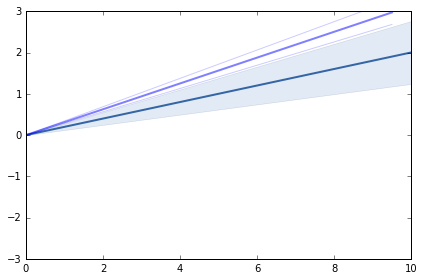

In [17]:
import GPy
import numpy as np

k = GPy.kern.Linear(1,variances=[1.0])
# !!! How can we later specify which dimensions the linear mean function mapping is over??
m = GPy.models.GPRegression(X[:,None],Y[:,None],k,mean_function=GPy.mappings.Linear(1,1))
#m = GPy.models.GPRegression(X,Y,k)

# !!! how do we specify the prior on this? I can use 'fix' but I also want to specify the uncertainty...
m.linmap.A.fix(priormean) 
#m.linmap.A.priors.add(GPy.priors.Gaussian(priormean,np.sqrt(priorvariance)),0)

m.linear.variances.fix(1.0) #the effect of the prior interacts with this...
m.Gaussian_noise.fix(noisevar)
#m.optimize()
print m
m.plot_latent(plot_limits=[0,10],legend=None)
plt.plot(Xstars,resmu,'b-',lw=2,alpha=0.5);
plt.plot(Xstars,resmu+np.sqrt(ressigmasqr),'b-',alpha=0.2);
plt.plot(Xstars,resmu-np.sqrt(ressigmasqr),'b-',alpha=0.2);
plt.ylim([-3,3])

## Other fixes?
How to get this working in GPy?

### Using an additional datapoint to "induce" a prior (a bit hacky?)

Could we just add a data point at the right location (with the right noise variance) to cause the regression to have a prior?

If our additional point is far enough from the data, then we can simply consider the effect of it on a prediction without data, at that point.

So at this large $X_*$, we have that the covariance in our model is $\phi(X_*) \sigma_p^2 \phi(X_*) = X_*^2 \sigma_p^2$. As we are considering a point sufficiently large (or without other data) we can see that for a prediction at that point to have the correct noise ($X_*^2 \sigma_p^2$), we need to place an additional input there, with uncertainty $X^2 \sigma_p^2$.

This is what is introduced below, and we can see that the result matches the earlier analytical solution:


Name : GP regression
Objective : 23.0025306187
Number of Parameters : 8
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.             |  value  |  constraints  |  priors
  sum.linear.variances       |    1.0  |   +ve fixed   |        
  sum.white_hetero.variance  |   (6,)  |      +ve      |        
  Gaussian_noise.variance    |   0.25  |   +ve fixed   |        


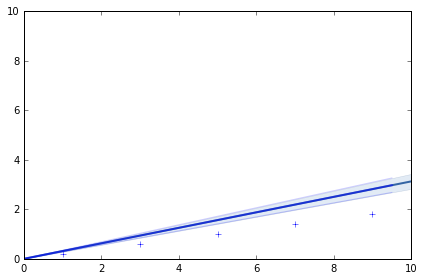

In [24]:
k = GPy.kern.Linear(1,variances=[1.0])

tempX = 10000.0
newX = np.r_[X,tempX]
newY = np.r_[Y,priormean*phi(tempX)]

variances = np.zeros(len(newX))
variances[-1] = tempX**2 * priorvariance
k = k + GPy.kern.WhiteHeteroscedastic(1,len(newX),variances)


m = GPy.models.GPRegression(newX[:,None],newY[:,None],k)

m.sum.linear.variances.fix(1.0)
m.Gaussian_noise.fix(noisevar)
#m.optimize()
print m
m.plot_latent(plot_limits=[0,10],legend=None,lower=16.2, upper=83.8) #plot one std
plt.ylim([0,10])
plt.plot(X,Y,'+')
plt.plot(Xstars,resmu,'b-',lw=2,alpha=0.5);
plt.plot(Xstars,resmu+np.sqrt(ressigmasqr),'b-',alpha=0.2);
plt.plot(Xstars,resmu-np.sqrt(ressigmasqr),'b-',alpha=0.2);

note the match to the previous analytical solution, but using standard GPy.

### Other options: Build a new kernel

We may need to build a new kernel, however, I think we'll need to include a mean function - I don't see how a covariance change on its own could include a prior. For example, if all your data was 0, there wouldn't be a data point to provide the positive gradient one might be a-priori expecting.

<hr/><hr/><hr/><hr/>

${}^1$ Colleagues have recommended that we combine all the patients into one large coregionalised model. This has several problems: excessive computational demands, privacy (having to share the data), interpretability (the gradient might be a useful feature), etc. We also might have a prior on this from medical literature and other studies${}^2$

${}^2$ I plan on fitting another model, of gradients wrt patient demographics etc to make predictions for the priors of the patients.